<a href="https://colab.research.google.com/github/oscarserc/TESIS/blob/main/PASO_3b___CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UTILIZACIÓN DE TÉCNICAS DE APRENDIZAJE AUTOMÁTICO PARA LA DETECCIÓN DE LOS NODOS INFLUYENTES.

La base de datos que emplearemos será de unas 70.000 observaciones. En concreto:

· 72.000 observaciones

· Para ello generamos una 1800 **simulaciones**, y guardamos unos 40 **frames** de cada una de ellas

· Además como **target** guardamos la matriz con la IDENTIDAD de todos y cada uno de los AGENTES.



#**PRUEBA 2**: Utilizaremos una <font color='green'>**RED NEURONAL CONVOLUCIONAL**</font>. Planteamos el problema de localizar a los agentes influyentes como un problema de **Segmentación** de imágenes.

La estructura que hemos probado de partida es la que aparece a continuación.


<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/CNN_1c_prueba.png?raw=true' width="850"/>
<figcaption></figcaption></center>
</figure>


El archivo de prueba contiene 4000 simulaciones de una población de AGENTES EMOCIONALES, y otras 4000 de agentes TRAIDORES (de la observación 4001 a la 8000).


<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Archivo_D.png?raw=true' width="950"/>
<figcaption></figcaption></center>
</figure>





Podemos comenzar **aleatorizando**, y después manteniendo agrupadas las observaciones (frames) que forman parte de la misma Simulación (animación).

#CARGA DE LA BASE DE DATOS (mezcla agentes **emocionales** y mutantes **traidores**).

#DESPUÉS ALEATORIZAMOS.

In [ ]:

import pandas as pd

# Cargamos los datos
# ------------------
bd_simulaciones = pd.read_csv('bd_combinado.csv')

# Aleatorizamos
# -------------
bd_simulaciones = bd_simulaciones.sample(frac=1).reset_index(drop=True)



#Variables explicativas: **X**

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

size   = 10
agente = 0
df     = bd_simulaciones.copy()

lista_frames = []
X            = []

nombre_columnas_ROJO  = ['r' + str(indice) for indice in range(size*size)]
nombre_columnas_VERDE = ['g' + str(indice) for indice in range(size*size)]
nombre_columnas_AZUL  = ['b' + str(indice) for indice in range(size*size)]


for fila in range(len(bd_simulaciones)):
  canal_r = pd.array(df[nombre_columnas_ROJO].iloc[fila]).reshape(size,size)
  canal_v = pd.array(df[nombre_columnas_VERDE].iloc[fila]).reshape(size,size)
  canal_a = pd.array(df[nombre_columnas_AZUL].iloc[fila]).reshape(size,size)

  # CUIDADO que np.dstack apila los tres valores de cada pixel
  # ----------------------------------------------------------
  frame = np.array([canal_r, canal_v, canal_a])

  lista_frames.append(frame)

X = np.array(lista_frames)
X.shape


(8000, 3, 10, 10)

#Target: **Y**.

In [ ]:

lista_targets = []

for fila in range(len(bd_simulaciones)):
  lista_id_agentes = bd_simulaciones.iloc[fila]['Target'].replace('[','').replace(']','')
  target = [int(caracter) for caracter in lista_id_agentes.split(',')]
  target = np.array(target)
  target = target.reshape(size,size)

  # Con los paréntesis  '['  ']' sale de dimensión: (8000, 1, 10, 10)   # <-------------------------- Aquí ajusto la DIMENSIÓN
  #lista_targets.append([target])
  # Si queremos de dimensión: (8000, 10, 10)
  lista_targets.append(target)

Y = np.array(lista_targets)
Y.shape


(8000, 10, 10)

#**CONVERSIÓN EN TENSORES DE PyTorch**.

In [ ]:

import numpy as np
import torch

# PRIMERO TENEMOS QUE EXTRAER LA MATRIX:  X
# y los valores del TARGET:               Y
#
# Luego pasaremos (X, Y) al Dataset que creamos a continuación.
# --------------------------------------------------------------

X_train = X
Y_train = Y                 

# CREAMOS UNA CLASE PARA LOS DATOS
# ================================

class Dataset_frames(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X).float()
    self.Y = torch.tensor(Y).long()

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return self.X[ix], self.Y[ix]


# SELECCIONANDO GRUPOS DE OBSERVACIONES PARA VALIDACIÓN
# -----------------------------------------------------

from sklearn.model_selection import train_test_split

X_subset, X_val, Y_subset, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

dataset = {
    'train' : Dataset_frames(X_subset, Y_subset),
    'val'   : Dataset_frames(X_val, Y_val)
}    

dataloader = {
    'train' : torch.utils.data.DataLoader(dataset['train'], batch_size=40,   shuffle=False),
    'val'   : torch.utils.data.DataLoader(dataset['val'],   batch_size=40, shuffle=False)
}


In [ ]:

frames, mascara = next(iter(dataloader['train']))
frames.shape, mascara.shape


(torch.Size([40, 3, 10, 10]), torch.Size([40, 10, 10]))

#**DEFINICIÓN DE LA RED Y MÉTODO PARA EL ENTRENAMIENTO**.

In [ ]:

from sklearn.metrics import accuracy_score

# Fijamos el número de canales y filtros
# --------------------------------------
c           = 3
n_filtros   = 6
kernel_size = 3

# CONSTRUIMOS EL MODELO
# =====================

def softmax(x):
  return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

# ---------------------------------------------------------------------
# Probamos inicialmente con un grid (10x10)
# ---------------------------------------------------------------------

def build_model(c=3, n_filtros=6, kernel_size=3):        # <-------------------------------------------------------- MODIFICAR (Definir la RED CONVOLUCIONAL)
  padding = kernel_size // 2
  model = torch.nn.Sequential(
      torch.nn.Conv2d(c, n_filtros, kernel_size, padding=padding),
      torch.nn.ReLU(),
      torch.nn.Conv2d(n_filtros, 2, (3,3), padding=1)
  )
  return model


# DEFINIMOS LA FUNCIÓN DE ENTRENAMIENTO
# =====================================

def fit(model, dataloader, epochs=10, log_each=1):
   criterion = torch.nn.CrossEntropyLoss()
   optimizer = torch.optim.SGD(model.parameters(), lr=0.8)

   l, acc         = [], []
   val_l, val_acc = [], []
   
   for e in range(1, epochs+1):
      _l, _acc = [], []
      model.train()  # <------------------------------------------ MODO de ENTRENAMIENTO
      for x_b, y_b in dataloader['train']:
        y_pred = model(x_b)
        loss   = criterion(y_pred, y_b)  
        _l.append(loss.item())                                                                        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_probas = torch.argmax(softmax(y_pred), axis=1)
        # Los SCORES de SKLEARN no aceptan matrices, así que hay que convertirlas en dimensión 1D (usar flatten())
        _acc.append(accuracy_score(y_b.numpy().flatten(), y_probas.detach().numpy().flatten()))

      l.append(np.mean(_l))
      acc.append(np.mean(_acc))
      if not e % log_each:
        print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f}")
        #print(f"Epoch {e}/{epochs} loss {l[-1]:.5f}")


      model.eval()  # <------------------------------------------- MODO de EVALUACIÓN
      _l, _acc = [], []
      with torch.no_grad():
        for x_b, y_b in dataloader['val']:
          y_pred = model(x_b)
          loss   = criterion(y_pred, y_b)
          _l.append(loss.item())
          y_probas = torch.argmax(softmax(y_pred), axis=1)
          _acc.append(accuracy_score(y_b.numpy().flatten(), y_probas.numpy().flatten()))
      val_l.append(np.mean(_l))
      val_acc.append(np.mean(_acc))  

   return {'epoch':list(range(1,epochs+1)), 'loss':l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}  
   #return {'epoch':list(range(1,epochs+1)), 'loss':l, 'val_loss': val_l} 



#**Nos preparamos para entrenar el modelo**.

In [ ]:

# INSTANCIAMOS EL MODELO
# ======================

model  = build_model()
hist   = fit(model, dataloader, 10)


Epoch 1/10 loss 0.06356 acc 0.79961
Epoch 2/10 loss 0.01470 acc 0.85572
Epoch 3/10 loss 0.01247 acc 0.85900
Epoch 4/10 loss 0.01116 acc 0.86425
Epoch 5/10 loss 0.01022 acc 0.86675
Epoch 6/10 loss 0.00947 acc 0.86751
Epoch 7/10 loss 0.00883 acc 0.86823
Epoch 8/10 loss 0.00829 acc 0.86872
Epoch 9/10 loss 0.00781 acc 0.86888
Epoch 10/10 loss 0.00738 acc 0.86903


In [ ]:

from torchsummary import summary

#print(model)

# EMPLEAR:
# from torchsummary import summary
# summary(your_model, input_size=(channels, H, W))
# -------------------------------------------------

# Supongo que podría valer: (3, 10, 10)
summary(model, input_size=(3, 10, 10))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 10, 10]             168
              ReLU-2            [-1, 6, 10, 10]               0
            Conv2d-3            [-1, 2, 10, 10]             110
Total params: 278
Trainable params: 278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


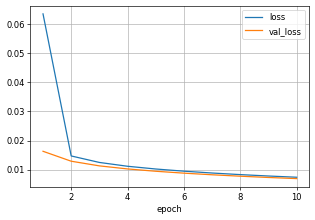

In [ ]:

# GRAFICAMOS LOS RESULTADOS DEL APRENDIZAJE
# =========================================

import matplotlib.pyplot as plt

fig = plt.figure(dpi=60)
#fig = plt.figure(figsize=(10,6))
ax  = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', y=['loss','val_loss'], grid=True, ax=ax)
#lt.ylim([0,0.010])
plt.show()


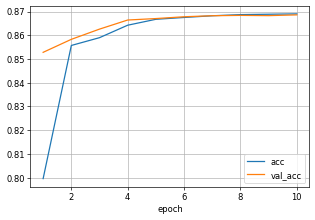

In [ ]:

# GRAFICAMOS LOS RESULTADOS DEL APRENDIZAJE
# =========================================

import matplotlib.pyplot as plt

fig = plt.figure(dpi=60)
#fig = plt.figure(figsize=(10,6))
ax  = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', y=['acc','val_acc'], grid=True, ax=ax)
#lt.ylim([0,0.010])
plt.show()
